In [ ]:
!pip install captum
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
import numpy as np

# Import dataset utils
from torch.utils.data import Dataset, DataLoader 
from sklearn.model_selection import train_test_split

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

In [ ]:
dataframe = pd.read_csv('/content/final.csv', sep=';')
dataframe.head()

,sexo,Estado_civil,Status_empl,Licenca,Tipo_Resid,Residencia,Alcoolatra,Droga,Suic_familia,Dep_familia,...,Eixo I: Panico sem agorafobia,Eixo I: Fobia especifica,Eixo I: Fobia social,Eixo I: Obsessivo-compulsivo,Eixo I: Estresse pos-traumatico,Eixo I: Ansiedade generalizada,Eixo II: Personalidade paranoica,Eixo II: Transtorno de personalidade,TOC,idade
0,M,3.0,NaN,0.0,3.0,1.0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,40.0
1,F,1.0,3.0,0.0,4.0,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0
2,F,1.0,2.0,0.0,1.0,2.0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
3,F,1.0,3.0,0.0,1.0,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,30.0
4,F,4.0,2.0,0.0,1.0,NaN,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0


In [ ]:
#último grafo cris: 8 features
selected = ['Suicidio', 'Drog_familia', 'Suic_familia',
                    'Capaz de tomar decisões importantes', 'Estudante',
                    'Hipocondriase', 'Sentimentos_culpa', 
                    'Trabalho e interesses', 'Energia']


In [ ]:
dataframe['sexo'].replace({'M': 0, 'F': 1}, inplace=True)
dataframe['sexo'].fillna(0, inplace=True)

df_suic = dataframe[selected]

df_suic.dropna(inplace=True)
df_suic = df_suic.astype(int)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_suic

,Suicidio,Drog_familia,Suic_familia,Capaz de tomar decisões importantes,Estudante,Hipocondriase,Sentimentos_culpa,Trabalho e interesses,Energia
0,2,1,0,2,0,2,3,2,2
1,1,0,0,1,0,0,2,2,2
2,0,1,1,2,0,0,3,3,2
3,3,0,0,1,0,3,4,3,2
4,1,0,0,2,0,1,2,4,2
...,...,...,...,...,...,...,...,...,...
3948,2,1,0,2,0,0,3,2,2
3949,1,0,0,1,0,2,2,2,1
3950,2,0,0,1,0,2,3,3,2
3951,0,0,0,2,0,1,1,2,1


In [ ]:
class MyDataset(Dataset):
 
  def __init__(self, input_dataframe, split="train", target="Suicidio", ignore_columns=[], train_ratio=0.8): 
    
    self.split = split
    self.target = target
    self.ignore_columns = ignore_columns

    for coll in self.ignore_columns:
       if coll in input_dataframe.columns:
        input_dataframe = input_dataframe.drop(coll, axis=1)

    self.classification_dim = len(input_dataframe[self.target].unique())
    self.data_dim = len(input_dataframe.columns) - 1
    self.embbeding_dim = input_dataframe.max().max() + 1

    y = input_dataframe[target].values 
    x = input_dataframe.drop(target, axis = 1).values 

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=42) 

  def __len__(self):
    if self.split == "train":
      return len(self.x_train)
    elif self.split == "test":
      return len(self.x_test)
    else:
      raise ValueError("Split must be train or test")

  def __getitem__(self,idx):
      target = torch.zeros(self.classification_dim) 
      if self.split == "train":
          target[self.y_train[idx]] = 1
          return (torch.tensor(self.x_train[idx]), target) 
      elif self.split == "test":
          target[self.y_test[idx]] = 1
          return (torch.tensor(self.x_test[idx]), target)
      else:
          raise ValueError("Split must be train or test")

In [ ]:
# Define a MLP model with N layers: rede neural de 2 camadas

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_layers=2):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
    
        self.layers = nn.ModuleList() 
        self.layers.append(nn.Linear(self.input_dim, self.hidden_dim)) 
        for i in range(self.n_layers - 1):
            self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.append(nn.Dropout(0.5)) 
            self.layers.append(nn.LeakyReLU())
            
        self.layers.append(nn.Linear(self.hidden_dim, self.output_dim))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)           
        return x


In [ ]:
# Define a Model with a embbeding layer and a MLP

class ClassificationModel(nn.Module):
    def __init__(self, input_dim, output_dim, embbeding_dim, hidden_out, hidden_dim=128, n_layers=2):   
        super(ClassificationModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embbeding_dim = embbeding_dim
        self.embbeding_out = hidden_out
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embbeding_layer = nn.Embedding(self.embbeding_dim, self.embbeding_out) 
        self.mlp = MLP(self.input_dim * self.embbeding_out, self.output_dim, self.hidden_dim, self.n_layers) 
        
    def forward(self, x):
        x = self.embbeding_layer(x)
        x = x.view(x.shape[0], -1)
        x = self.mlp(x)
        ## classification
        x = F.softmax(x, dim=1)
        return x

In [ ]:
# Make Lightning Module
from pytorch_lightning import LightningModule
from torchmetrics import MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy

class BaseModel(LightningModule):
    """A LightningModule organizes your PyTorch code into 6 sections:
        - Computations (init)
        - Validation loop (validation_step)
        - Train loop (training_step)
        - Test loop (test_step)
        - Prediction Loop (predict_step)
        - Optimizers and LR Schedulers (configure_optimizers)
    """

    def __init__(self, input_dim, output_dim, embedding_dim, embedding_out, hidden_dim):
        super().__init__()
        self.model = ClassificationModel(input_dim, output_dim, embedding_dim, embedding_out, hidden_dim=hidden_dim, n_layers=2)
        self.lr = 1e-3 # taxa de aprendizado: 0.001

        self.save_hyperparameters()
        
        # metric objects for calculating and averaging accuracy across batches
        self.accuracy = Accuracy(task='multiclass', num_classes=5)
        
        # for tracking best so far validation accuracy
        self.val_acc_best = MaxMetric()
    
    def step(self, batch):
        x, y = batch
        y_hat = self.model(x).squeeze().float()
        # loss function
        loss = F.binary_cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y.int())
        return loss, acc
   
    def training_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log('train_loss', loss, prog_bar=True)        
        self.log('train_acc', acc,  prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.step(batch)
        self.log('val_loss', loss)      
        self.log('val_acc', acc,  prog_bar=True)
        return loss
    
    # gradiente
    def configure_optimizers(self):
        """Choose what optimizers and learning-rate schedulers to use in your optimization.
        Normally you'd need one. But in the case of GANs or similar you might have multiple.

        Examples:
            https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#configure-optimizers
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
# Import trainer
from pytorch_lightning.trainer import Trainer

In [ ]:
# Import callbacks
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Initialize callbacks

# Salve o modelo periodicamente monitorando uma quantidade.
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/', 
    filename='best-checkpoint', 
    save_top_k=1, 
    mode='min',
)

# Monitore uma métrica e interrompa o treinamento quando ela parar de melhorar.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.05, 
    patience=10, 
    verbose=False, 
    mode='min' 
)

callbacks = [checkpoint_callback, early_stopping]


# Initialize a trainer
trainer = Trainer(
    #accelerator='gpu',
    accelerator='cpu', 
    devices=1, 
    check_val_every_n_epoch=10, 
    log_every_n_steps=10, 
    callbacks=callbacks, 
    auto_lr_find=True, 
    enable_progress_bar=False
    ) 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
model = BaseModel.load_from_checkpoint("/content/best-checkpoint-v31.ckpt")

In [ ]:
#from captum.attr import ShapleyValues
from captum.attr import ShapleyValueSampling

In [ ]:
df_suic_0 = df_suic.loc[df_suic.Suicidio == 0]
df_suic_1 = df_suic.loc[df_suic.Suicidio == 1]
df_suic_2 = df_suic.loc[df_suic.Suicidio == 2]
df_suic_3 = df_suic.loc[df_suic.Suicidio == 3]
df_suic_4 = df_suic.loc[df_suic.Suicidio == 4]

In [ ]:
svs = ShapleyValueSampling(model.model.forward)

In [ ]:
sample_df_suic_0 = df_suic_0.sample(n=10, random_state=42)
sample_df_suic_1 = df_suic_1.sample(n=10, random_state=42)
sample_df_suic_2 = df_suic_2.sample(n=10, random_state=42)
sample_df_suic_3 = df_suic_3.sample(n=10, random_state=42)
#sample_df_suic_4 = df_suic_4.sample(n=10, random_state=42)

In [ ]:
tensor_suic_0 = torch.tensor(df_suic_0.drop(labels='Suicidio', axis='columns').values)
tensor_suic_1 = torch.tensor(df_suic_1.drop(labels='Suicidio', axis='columns').values)
tensor_suic_2 = torch.tensor(df_suic_2.drop(labels='Suicidio', axis='columns').values)
tensor_suic_3 = torch.tensor(df_suic_3.drop(labels='Suicidio', axis='columns').values)
tensor_suic_4 = torch.tensor(df_suic_4.drop(labels='Suicidio', axis='columns').values)

In [ ]:
attr_tensor_suic_0 = svs.attribute(tensor_suic_0, target=0)
attr_tensor_suic_1 = svs.attribute(tensor_suic_1, target=1)
attr_tensor_suic_2 = svs.attribute(tensor_suic_2, target=2)
attr_tensor_suic_3 = svs.attribute(tensor_suic_3, target=3)
attr_tensor_suic_4 = svs.attribute(tensor_suic_4, target=4)

In [ ]:
feature_names = list(df_suic.drop(labels='Suicidio', axis='columns').columns)
feature_names

['Drog_familia',
 'Suic_familia',
 'Capaz de tomar decisões importantes',
 'Estudante',
 'Hipocondriase',
 'Sentimentos_culpa',
 'Trabalho e interesses',
 'Energia']

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xticks(rotation=20, ha='right')
        plt.xlabel("Features")
        plt.ylabel("Average Feature Importances")
        plt.grid(True)
        plt.title(title)

In [ ]:
attr_np_0 = attr_tensor_suic_0.detach().numpy()
attr_np_1 = attr_tensor_suic_1.detach().numpy()
attr_np_2 = attr_tensor_suic_2.detach().numpy()
attr_np_3 = attr_tensor_suic_3.detach().numpy()
attr_np_4 = attr_tensor_suic_4.detach().numpy()

Classe Suícidio = 0
Drog_familia :  -0.011
Suic_familia :  0.004
Capaz de tomar decisões importantes :  0.007
Estudante :  -0.002
Hipocondriase :  0.055
Sentimentos_culpa :  -0.133
Trabalho e interesses :  -0.205
Energia :  -0.009


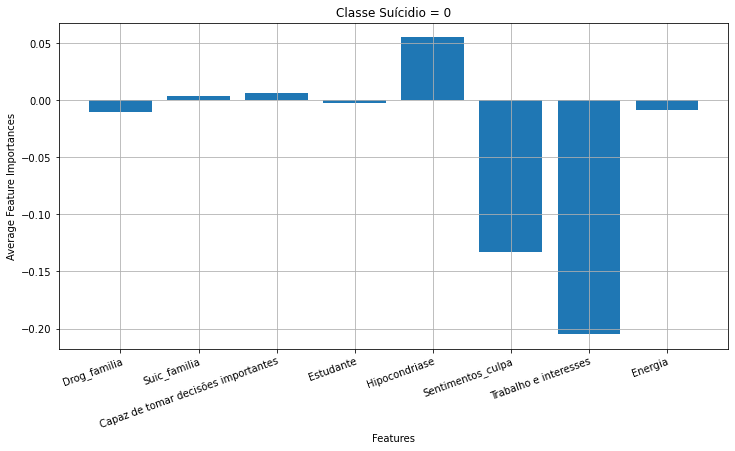

In [ ]:
visualize_importances(feature_names, np.mean(attr_np_0, axis=0), title="Classe Suícidio = 0")
plt.savefig("shap_suicidio_0.png")

Classe Suícidio = 1
Drog_familia :  0.005
Suic_familia :  -0.003
Capaz de tomar decisões importantes :  0.018
Estudante :  0.003
Hipocondriase :  -0.021
Sentimentos_culpa :  0.064
Trabalho e interesses :  0.125
Energia :  0.012


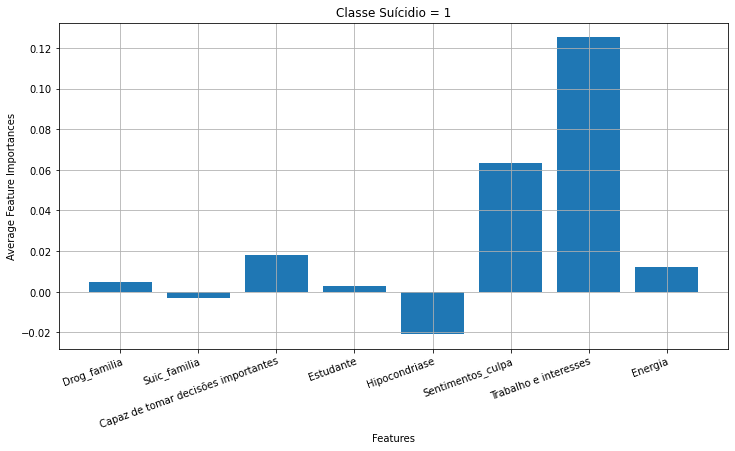

In [ ]:
visualize_importances(feature_names, np.mean(attr_np_1, axis=0), title="Classe Suícidio = 1")
plt.savefig("shap_suicidio_1.png")

Classe Suícidio = 2
Drog_familia :  0.003
Suic_familia :  0.001
Capaz de tomar decisões importantes :  -0.017
Estudante :  -0.001
Hipocondriase :  -0.006
Sentimentos_culpa :  0.069
Trabalho e interesses :  0.084
Energia :  0.003


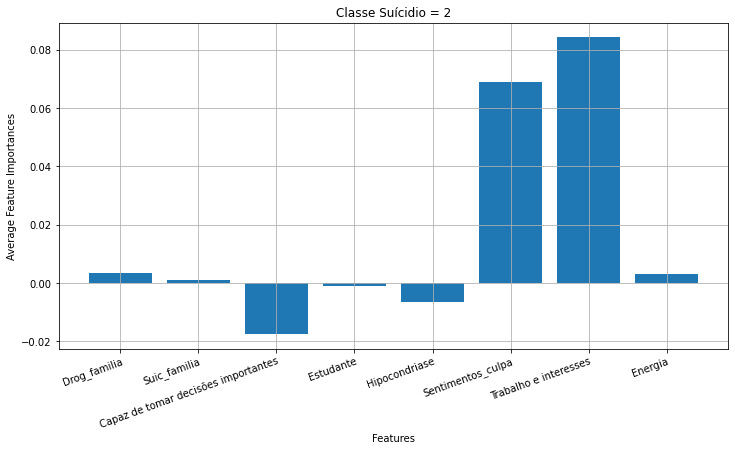

In [ ]:
visualize_importances(feature_names, np.mean(attr_np_2, axis=0), title="Classe Suícidio = 2")
plt.savefig("shap_suicidio_2.png")

Classe Suícidio = 3
Drog_familia :  -0.001
Suic_familia :  0.001
Capaz de tomar decisões importantes :  -0.009
Estudante :  -0.001
Hipocondriase :  -0.003
Sentimentos_culpa :  0.024
Trabalho e interesses :  0.021
Energia :  -0.004


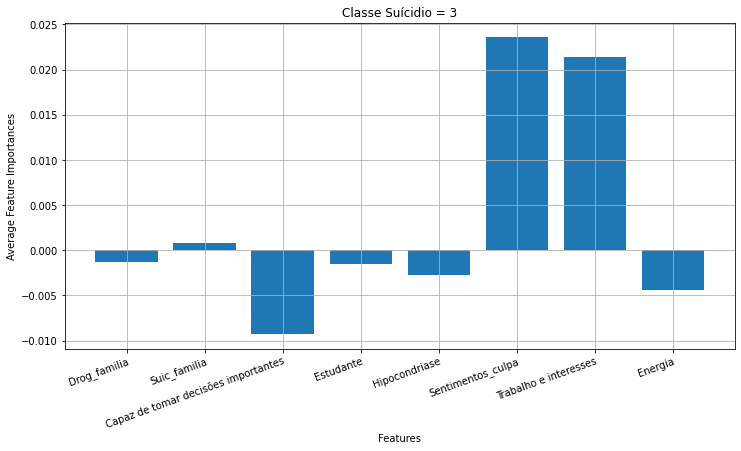

In [ ]:
visualize_importances(feature_names, np.mean(attr_np_3, axis=0), title="Classe Suícidio = 3")
plt.savefig("shap_suicidio_3.png")

Classe Suícidio = 4
Drog_familia :  -0.002
Suic_familia :  0.004
Capaz de tomar decisões importantes :  -0.007
Estudante :  0.001
Hipocondriase :  0.000
Sentimentos_culpa :  0.012
Trabalho e interesses :  0.009
Energia :  -0.002


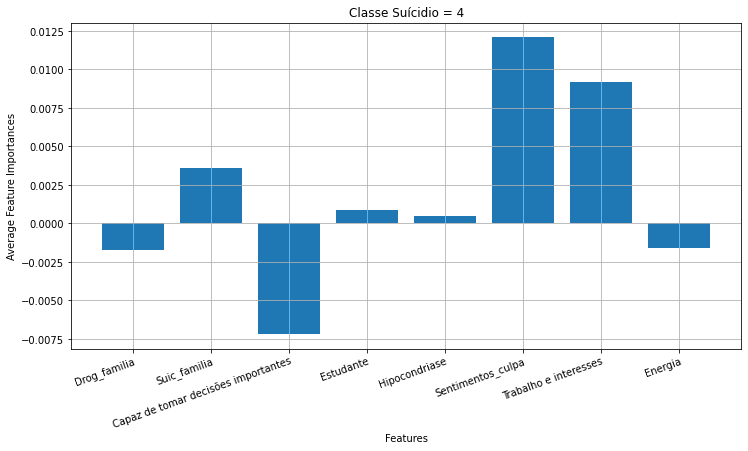

In [ ]:
visualize_importances(feature_names, np.mean(attr_np_4, axis=0), title="Classe Suícidio = 4")
plt.savefig("shap_suicidio_4.png")